<a href="https://colab.research.google.com/github/isocan/material-screen-from-MP/blob/main/Material_Screening_with_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name="sec-introduction"></a> Introduction


### Material Screening Workflow

This notebook demonstrates a systematic approach to materials screening using the Materials Project (MP) database. It specifically focuses on identifying bimetallic compounds, categorizing them as "in-domain" or "out-of-domain" based on their presence in the Open Catalyst 2020 (OC20) dataset, and enriching the data with additional computed properties from the Materials Project.

## Table of Contents  

* **[1. Introduction](#sec-introduction)**
* **[2. Prerequisites & Environment](#sec-env)**
* **[3. Data Sources](#sec-data-sources)**
* **[4. Step 1 – Query bimetallic entries](#sec-step1-query)**
* **[5. Step 2 – Label “in‑domain” vs “out‑of‑domain”](#sec-step2-label)**
* **[6. Step 3 – Enrich missing symmetry & properties](#sec-step3-enrich)**
  * [6.1 Predict symmetry locally](#subsec-symmetry-pred)
  * [6.2 Fill numeric gaps by composition match](#subsec-gap-fill)
* **[7. Step 4 – Exploratory visualisation](#sec-step4-viz)**
* **[8. Step 5 – Generate VASP input decks](#sec-step5-vasp)**
* **[9. Step 6 – Build the Out‑of‑Domain Bulk Pickle from VASP OUTCARs](#sec-outcar-extract)**
* **[10. Step 7 – Package merged pickle](#sec-step7-package)**
* **[11. Conclusions](#sec-conclusions)**
* **[12. References](#sec-references)**




### <a name="sec-env"></a> Prerequisites & Environment


##### Verify Python environment

In [7]:
!python --version

Python 3.11.13


##### Install and upgrade dependencies



In [8]:
!pip install --upgrade pip
!pip install pandas mp-api pymatgen ase tqdm matplotlib

##### Import core libraries

In [9]:
# ─────────────────────────────────────────────────────────────────────────────
# Standard library
# ─────────────────────────────────────────────────────────────────────────────
from pathlib import Path              # file paths / saving results
from itertools import combinations    # generate element pairs
import pickle                         # serialize filtered bulks (in_domain.pkl)
import ast                            # safe literal parsing (if needed for lists/tuples)
import os
import random

# ─────────────────────────────────────────────────────────────────────────────
# Third‑party scientific stack
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np                    # numeric utilities
import pandas as pd                   # tabular data wrangling
from tqdm import tqdm                 # progress bars for API loops
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
from matplotlib.patches import Patch

# ─────────────────────────────────────────────────────────────────────────────
# Atomistic / materials toolkits
# ─────────────────────────────────────────────────────────────────────────────
from ase import Atoms                                 # ASE structures in bulks.pkl
from ase.io import read
from ase.io import write
from ase.calculators.singlepoint import PropertyNotImplementedError
from ase.calculators.singlepoint import SinglePointCalculator
from mp_api.client import MPRester                    # Materials Project REST client
from pymatgen.core import Composition                 # chemistry utilities (parsing formulas)
from pymatgen.io.ase import AseAtomsAdaptor           # ASE↔pymatgen structure conversion
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer  # space‑group detection




> ⚠️ **Materials Project API key required**  
> Set it once per shell session  
> `export MP_API_KEY="YOUR_KEY"`  
> **or** replace the placeholder below:  
> ```python
> # Replace with your Materials Project API key
> API_KEY = "XXXXXXXXX"
> ```


### <a name="sec-data-sources"></a> Data Sources


### ⬇️ Loading the OC20 *bulks.pkl* dataset  

The **Open Catalyst Project** distributes pre‑computed bulk crystal structures
in a single pickle file, **`bulks.pkl`**.  
Each element of the list stored in this file is a small Python dictionary with:

| key | description |
|-----|-------------|
| `atoms` | an **ASE `Atoms`** object containing lattice vectors, atomic coordinates, and—if available—a `SinglePointCalculator` with the final DFT results |
| `src_id` | the canonical Materials Project identifier (e.g. `mp‑1234`) |
| `bulk_sampling_str` | OC20’s internal bookkeeping string for sampling provenance |

You can download the file directly from the project repository:  
<https://github.com/Open-Catalyst-Project/Open-Catalyst-Dataset/blob/main/ocdata/databases/pkls/bulks.pkl>

In [10]:
# ── Load OC20 bulks ────────────────────────────────────────────────────────
with open("/content/bulks.pkl", "rb") as f:
    bulks = pickle.load(f)   # → list[dict]

print(f"Loaded {len(bulks):,} bulk structures from OC20.")

# Quick sanity‑checks
first = bulks[0]
print("Keys in first entry:", list(first.keys()))
print("Example src_id:", first['src_id'])
print("ASE Atoms object:", first['atoms'])

Loaded 11,410 bulk structures from OC20.
Keys in first entry: ['atoms', 'src_id', 'bulk_sampling_str']
Example src_id: mp-8
ASE Atoms object: Atoms(symbols='Re2', pbc=True, cell=[[2.78232129, 0.0, 0.0], [-1.39116064, 2.40956092, 0.0], [0.0, 0.0, 4.49919228]], initial_charges=..., initial_magmoms=..., momenta=..., tags=..., calculator=SinglePointCalculator(...))


## 🔍 Bimetallic‐pair statistics  
The cell below scans the **`bulks`** list (loaded earlier) and counts how many
times every unique two‑metal combination appears.  
We then

1.  list the **most common** and **least common** pairs, and  
2.  draw a quick heat‑map so you can spot dominant vs. sparse regions at a glance.


🔝 Top 10 most frequent bimetallic pairs


,Ametal,Bmetal,count
0,Ni,Ti,14
1,Co,Ta,11
2,Cu,Ti,9
3,Co,Fe,8
4,Co,Ti,8
5,Co,Nb,8
6,Sn,Ti,8
7,Pt,Ti,7
8,Sb,Ti,7
9,Fe,Nb,7



🔻 Bottom 10 least frequent pairs


,Ametal,Bmetal,count
62,Fe,Ru,1
63,Fe,Sn,1
64,Mo,Nb,1
65,Mo,Ru,1
66,Mo,Sb,1
67,Mo,Ta,1
68,Pt,Sn,1
69,Pt,Ru,1
70,Ru,Ti,1
71,Sn,Ta,1


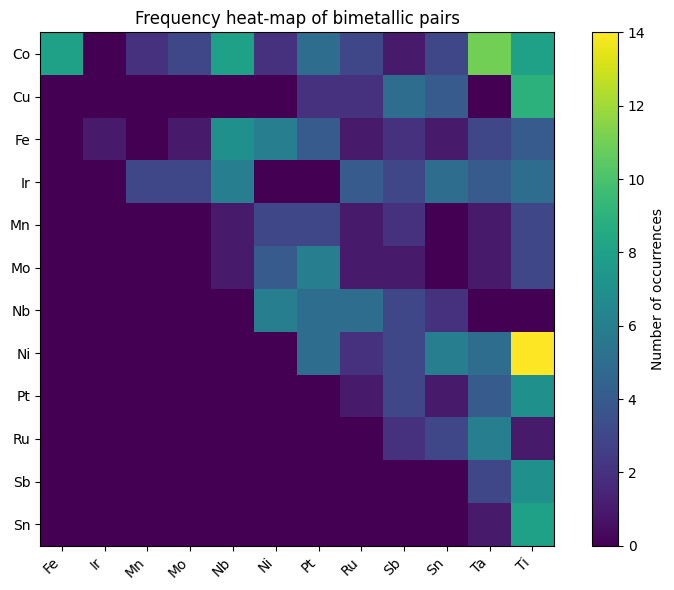

In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# Parameters
# ─────────────────────────────────────────────────────────────────────────────
symbols_of_interest = {
    "Ir","Pt","Ru","Ni","Fe","Mo","Ta","Nb","Ti","Cu","Sb","Mn","Co","Sn"
}

# ─────────────────────────────────────────────────────────────────────────────
# Build a DataFrame of all bimetal pairs in `bulks`
# ─────────────────────────────────────────────────────────────────────────────
rows = []
for entry in bulks:                           # `bulks` was loaded from bulks.pkl
    atoms = entry["atoms"]                   # ASE Atoms
    elems = sorted(set(atoms.get_chemical_symbols()))
    # keep only pairs fully within our element list
    if len(elems) == 2 and set(elems).issubset(symbols_of_interest):
        rows.append({"Ametal": elems[0], "Bmetal": elems[1]})

df_pairs = pd.DataFrame(rows)

# count frequencies
pair_counts = (
    df_pairs
    .groupby(["Ametal", "Bmetal"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

# ─── 1) Text summary ────────────────────────────────────────────────────────
TOP_N = 10
print(f"\n🔝 Top {TOP_N} most frequent bimetallic pairs")
display(pair_counts.head(TOP_N))

print(f"\n🔻 Bottom {TOP_N} least frequent pairs")
display(pair_counts.tail(TOP_N))

# ─── 2) Heat‑map visualisation ──────────────────────────────────────────────
import matplotlib.pyplot as plt

pivot = (
    pair_counts
    .pivot(index="Ametal", columns="Bmetal", values="count")
    .fillna(0)
    .astype(int)
)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(pivot.values, cmap="viridis")

# axis labels and ticks
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)

# colour‑bar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Number of occurrences")

ax.set_title("Frequency heat‑map of bimetallic pairs")
plt.tight_layout()
plt.show()


### <a name="sec-step1-query"></a> Step 1 – Query Bimetallic Entries


### 🔄 High‑throughput retrieval & labelling of bimetallic entries  
This code block:

1. **Enumerates every unique binary combination** of the 14 transition‑metal / post‑metal elements listed in `symbols`.  
2. **Queries the Materials Project** for each pair, requesting a compact but information‑rich set of fields (`FIELDS`).  
3. **Builds a tidy pandas table** (`df`) with crystal‑system, space‑group, formation‑energy, band‑gap and other key attributes.  
4. **Adds an `experimentally_observed` flag** – `True` when the MP record is tagged as *non‑theoretical* (or has an ICSD entry), `False` otherwise.  




In [12]:
# Replace with your Materials Project API key (or set MP_API_KEY env var)
API_KEY = "flLqcvJ9pBRAR92KRVful0lQV9GZ1m3O"

# Elements to search for
symbols = [
    "Ir", "Pt", "Ru", "Ni", "Fe", "Mo",
    "Ta", "Nb", "Ti", "Cu", "Sb", "Mn",
    "Co", "Sn"]

FIELDS = [
    "material_id",
    "chemsys",
    "formula_pretty",
    "symmetry",                   # full object → symbol, number, crystal_system, point_group
    "formation_energy_per_atom",
    "band_gap",
    "volume",
    "structure",                  # for volume fallback
    "elements",
    "nelements",
    "density",
    "energy_above_hull",
]

bimetal_docs = []
with MPRester(API_KEY) as mpr:
    seen = set()
    for a in tqdm(symbols, desc="outer"):
        seen.add(a)
        for b in symbols:
            if b in seen:      # skip reversed duplicates
                continue
            docs = mpr.materials.summary.search(
                elements=[a, b],
                num_elements=2,
                fields=FIELDS,
                chunk_size=100,
            )
            bimetal_docs.extend(docs)

print(f"Fetched {len(bimetal_docs)} bimetallic entries with full fields.")


outer:   0%|          | 0/14 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

outer:   7%|▋         | 1/14 [00:13<03:01, 13.98s/it]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

outer:  14%|█▍        | 2/14 [00:25<02:30, 12.56s/it]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

outer:  21%|██▏       | 3/14 [00:30<01:42,  9.29s/it]

Retrieving SummaryDoc documents:   0%|          | 0/17 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/16 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/18 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

outer:  29%|██▊       | 4/14 [00:36<01:20,  8.00s/it]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/13 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

outer:  36%|███▌      | 5/14 [00:42<01:05,  7.22s/it]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

outer:  43%|████▎     | 6/14 [00:46<00:48,  6.10s/it]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/14 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

outer:  50%|█████     | 7/14 [00:51<00:39,  5.69s/it]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

outer:  57%|█████▋    | 8/14 [00:55<00:30,  5.04s/it]

Retrieving SummaryDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/11 [00:00<?, ?it/s]

outer:  64%|██████▍   | 9/14 [00:58<00:21,  4.38s/it]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/16 [00:00<?, ?it/s]

outer:  71%|███████▏  | 10/14 [01:00<00:15,  3.79s/it]

Retrieving SummaryDoc documents:   0%|          | 0/16 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

outer:  79%|███████▊  | 11/14 [01:02<00:09,  3.15s/it]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

outer:  86%|████████▌ | 12/14 [01:03<00:05,  2.63s/it]

Retrieving SummaryDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

outer: 100%|██████████| 14/14 [01:04<00:00,  4.61s/it]

Fetched 552 bimetallic entries with full fields.


In [13]:
OUT_CSV = Path("bimetal_tidy.csv")

rows = []
for doc in bimetal_docs:
    sym = getattr(doc, "symmetry", None)

    space_group     = getattr(sym, "symbol", None) if sym else None
    sg_number       = getattr(sym, "number", None) if sym else None
    crystal_system  = getattr(sym, "crystal_system", None) if sym else None
    point_group     = getattr(sym, "point_group", None) if sym else None

    vol = getattr(doc, "volume", None)
    if vol is None and getattr(doc, "structure", None):
        try:
            vol = doc.structure.volume
        except Exception:
            pass

    rows.append(
        {
            "bulk_id":                    doc.material_id,
            "chemsys":                    doc.chemsys,
            "formula_pretty":             doc.formula_pretty,
            "nelements":                  getattr(doc, "nelements", None),
            "elements":                   getattr(doc, "elements", None),
            "band_gap":                   getattr(doc, "band_gap", None),
            "formation_energy_per_atom":  getattr(doc, "formation_energy_per_atom", None),
            "energy_above_hull":          getattr(doc, "energy_above_hull", None),
            "density":                    getattr(doc, "density", None),
            "volume":                     vol,
            "spacegroup":                 space_group,
            "sg_number":                  sg_number,
            "crystal_system":             crystal_system,
            "point_group":                point_group,
        }
    )

df = pd.DataFrame(rows)

# stable column order
cols = [
    "chemsys", "bulk_id","formula_pretty","crystal_system", "spacegroup","volume", "formation_energy_per_atom",
     "band_gap"]

df = df[cols].drop_duplicates("bulk_id").reset_index(drop=True)

df.to_csv(OUT_CSV, index=False)
print(f"saved → {OUT_CSV.resolve()}")
display(df.head())


saved → /content/bimetal_tidy.csv


,chemsys,bulk_id,formula_pretty,crystal_system,spacegroup,volume,formation_energy_per_atom,band_gap
0,Ir-Pt,mp-1223665,IrPt,Trigonal,R-3m,30.221598,0.081435,0.0
1,Ir-Pt,mp-1184759,IrPt3,Cubic,Pm-3m,61.688543,0.081637,0.0
2,Ir-Ru,mp-974358,Ir3Ru,Tetragonal,I4/mmm,56.413245,-0.041020,0.0
3,Ir-Ru,mp-1223860,IrRu,Trigonal,R-3m,27.864586,-0.018449,0.0
4,Ir-Ru,mp-974421,IrRu,Hexagonal,P-6m2,27.847280,-0.037188,0.0


In [14]:

def add_experimentally_observed(df: pd.DataFrame, api_key: str, batch=100) -> pd.DataFrame:
    """
    Add a boolean column 'experimentally_observed' using MP Summary 'theoretical' flag.
    Falls back to checking 'icsd_ids' from get_data_by_id when needed.
    """
    df = df.copy()
    df["experimentally_observed"] = pd.NA

    ids = df["bulk_id"].dropna().astype(str).unique().tolist()
    if not ids:
        return df

    with MPRester(api_key) as mpr:
        # ---- primary: use Summary search → theoretical ----
        fields = ["material_id", "theoretical"]
        for i in range(0, len(ids), batch):
            chunk = ids[i:i+batch]
            docs = mpr.materials.summary.search(material_ids=chunk, fields=fields, chunk_size=len(chunk))
            for d in docs:
                df.loc[df["bulk_id"] == d.material_id, "experimentally_observed"] = (not bool(d.theoretical))

        # ---- fallback: if anything still NA, check for ICSD entries ----
        missing = df["experimentally_observed"].isna()
        if missing.any():
            for mid in df.loc[missing, "bulk_id"].astype(str).unique():
                try:
                    # use_document_model=False returns plain dict; safer for probing keys
                    doc = mpr.materials.summary.get_data_by_id(mid, fields=["theoretical", "icsd_ids"],
                                                               use_document_model=False)
                    # get_data_by_id may return a list or a dict depending on version; normalize
                    if isinstance(doc, list) and doc:
                        doc = doc[0]
                    theoretical = doc.get("theoretical", None)
                    icsd_ids = doc.get("icsd_ids", []) or []
                    if theoretical is not None:
                        val = not bool(theoretical)
                    else:
                        # if theoretical missing, consider ICSD presence as "observed"
                        val = bool(icsd_ids)
                    df.loc[df["bulk_id"] == mid, "experimentally_observed"] = val
                except Exception:
                    # leave as NA if anything goes wrong
                    pass

    # cast to boolean where possible
    df["experimentally_observed"] = df["experimentally_observed"].astype("boolean")
    return df


In [15]:
df = add_experimentally_observed(df,  API_KEY)

Retrieving SummaryDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/52 [00:00<?, ?it/s]

In [16]:
df['experimentally_observed'].value_counts()

,count
experimentally_observed,
False,311
True,241


### <a name="sec-step2-label"></a> Step 2 – Label “In‑Domain” vs “Out‑of‑Domain”


<span id="md‑in‑domain"></span>1  Tag OC20 structures (in_domain flag)


Adds an in_domain boolean column to our master dataframe df.

In [17]:
import pickle

# 1. Load the pickled list of dicts
with open('/content/bulks.pkl', 'rb') as f:
    bulks = pickle.load(f)  # bulks

# 2. Extract all src_id values
#    We know each entry is a dict with key 'src_id'
src_ids = {entry['src_id'] for entry in bulks if 'src_id' in entry}  # list-of-dicts

# 3. Flag DataFrame rows whose bulk_id is in that set
df['in_domain'] = df['bulk_id'].isin(src_ids)

# 4. Quick check
print(f"Found {len(src_ids)} unique src_id values in bulks.pkl")
print(df[['bulk_id', 'in_domain']].head(10))


Found 11410 unique src_id values in bulks.pkl
      bulk_id  in_domain
0  mp-1223665      False
1  mp-1184759      False
2   mp-974358       True
3  mp-1223860       True
4   mp-974421       True
5   mp-862620       True
6  mp-1220071      False
7  mp-1186350      False
8  mp-1224967      False
9  mp-1184336      False


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   chemsys                    552 non-null    object 
 1   bulk_id                    552 non-null    object 
 2   formula_pretty             552 non-null    object 
 3   crystal_system             552 non-null    object 
 4   spacegroup                 552 non-null    object 
 5   volume                     552 non-null    float64
 6   formation_energy_per_atom  552 non-null    float64
 7   band_gap                   552 non-null    float64
 8   experimentally_observed    552 non-null    boolean
 9   in_domain                  552 non-null    bool   
dtypes: bool(1), boolean(1), float64(3), object(5)
memory usage: 36.2+ KB


<span id="md‑sym‑stats"></span>2  Crystal‑system / space‑group statistics

Here we group the dataframe by crystal_system and spacegroup to inspect

*   average unit‑cell volume (Mean Volume),
*   population count (Count), and
*   the list of bulk IDs that fall into each symmetry bin.



In [19]:
# Group by crystal system and symbol
grouped = df.groupby(['crystal_system', 'spacegroup'], sort=False)

# Perform aggregations: mean and count of volume, and list out bulk_ids
aggregated_data = grouped.agg({
    'volume': ['mean', 'count'],
    'bulk_id': lambda x: list(x)
})

# Rename columns for clarity
aggregated_data.columns = ['Mean Volume', 'Count', 'Bulk IDs']

# Sort by mean volume descending
sorted_aggregated_data = aggregated_data.sort_values(by='Mean Volume', ascending=False)

# Display the full aggregated table
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(sorted_aggregated_data)


                           Mean Volume  Count  \
crystal_system spacegroup                       
Trigonal       R-3c        1238.232168      1   
Monoclinic     Pm           905.486527      1   
Triclinic      P-1          847.073445      2   
Trigonal       R3m          772.635518      2   
Monoclinic     C2/c         724.888494      2   
Triclinic      P1           710.831046      3   
Tetragonal     I4_1/acd     570.609986      2   
Orthorhombic   Pbam         495.762637      2   
Tetragonal     P4_2/mnm     488.934410      2   
Monoclinic     C2           471.021189      1   
Orthorhombic   Cmm2         458.867090      1   
Monoclinic     Cm           436.976220      1   
Orthorhombic   Pnma         404.152098      7   
Trigonal       P-31m        396.907861      1   
Cubic          Im-3         387.227400      4   
Tetragonal     P-4c2        384.100776      1   
Monoclinic     P2_1/c       379.533626      3   
Hexagonal      P6_222       375.606799      1   
Orthorhombic   Cmce 

### Symmetry–volume overview
* Rare, low-symmetry lattices (e.g., triclinic **P-1**, monoclinic **C2/c**) show the **largest mean volumes** (> 700 Å³).  
* Common high-symmetry groups (cubic **Fm-3 m**, hexagonal **P6₃/mmc**) cluster at **smaller volumes** (≈ 60–135 Å³) and dominate the dataset.

In [20]:
df['spacegroup'].value_counts().head(10)

,count
spacegroup,
P6_3/mmc,85
Pm-3m,70
R-3m,48
I4/mmm,33
Fm-3m,31
P-6m2,28
P4/mmm,28
Cmmm,25
Fd-3m,18


In [21]:
df['crystal_system'].value_counts().head(5)

,count
crystal_system,
Cubic,149
Hexagonal,126
Orthorhombic,97
Tetragonal,86
Trigonal,67


### Why we filter
* Retain the five most frequent crystal systems: **Cubic, Hexagonal, Orthorhombic, Tetragonal, Trigonal**.  
* Choose space groups that are (i) well-populated, (ii) span P/I/F centering, and (iii) keep **mean volumes < 135 Å³**.

In [22]:

selected_spacegroups = [
    # ── cubic ──
    "Pm-3m", "Fm-3m", "Fd-3m", "Pm-3n", "Im-3m",
    # ── orthorhombic ──
    "Cmmm", "Pmmn", "Pmma", "Fmmm", "Immm", "Pnnm",
    # ── tetragonal ──
    "I4/mmm", "P4/mmm", "I4/mcm",
    # ── hexagonal ──
    "P6_3/mmc",
    "P-6m2",
    # ── trigonal ──
    "R-3m",
]

df_selected = df[
    df["spacegroup"].isin(selected_spacegroups)
].copy()

df_selected.reset_index(drop=True, inplace=True)


display(df_selected.head())

,chemsys,bulk_id,formula_pretty,crystal_system,spacegroup,volume,formation_energy_per_atom,band_gap,experimentally_observed,in_domain
0,Ir-Pt,mp-1223665,IrPt,Trigonal,R-3m,30.221598,0.081435,0.0,False,False
1,Ir-Pt,mp-1184759,IrPt3,Cubic,Pm-3m,61.688543,0.081637,0.0,False,False
2,Ir-Ru,mp-974358,Ir3Ru,Tetragonal,I4/mmm,56.413245,-0.041020,0.0,False,True
3,Ir-Ru,mp-1223860,IrRu,Trigonal,R-3m,27.864586,-0.018449,0.0,False,True
4,Ir-Ru,mp-974421,IrRu,Hexagonal,P-6m2,27.847280,-0.037188,0.0,False,True


In [23]:
df_in = df_selected[df_selected["in_domain"]].copy()

In [24]:
df_in['band_gap'].value_counts()

,count
band_gap,
0.0000,203
0.0035,1


<Axes: >

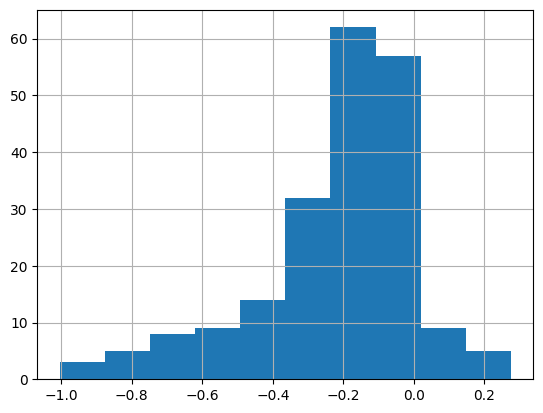

In [25]:
df_in['formation_energy_per_atom'].hist()

<span id="md‑save‑subset"></span>4  Save OC20‑matching structures (in_domain.pkl)
This final cell pulls the actual bulk structures (ASE Atoms objects) that
correspond to the IDs in df_in, then saves the subset as in_domain.pkl

In [26]:
# --- paths ---
OUT_PKL   = "/content/in_domain.pkl"   # output

# --- 1) get the whitelist of IDs from df_in ---
assert "bulk_id" in df_in.columns, "df_in must have a 'bulk_id' column"
allowed_ids = set(df_in["bulk_id"].astype(str).unique())


# --- 3) filter by src_id ∈ allowed_ids ---
in_domain = [entry for entry in bulks
             if isinstance(entry, dict) and str(entry.get("src_id")) in allowed_ids]

# --- 4) save subset ---
with open(OUT_PKL, "wb") as f:
    pickle.dump(in_domain, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"bulks total:   {len(bulks)}")
print(f"unique IDs in df_in: {len(allowed_ids)}")
print(f"kept (in-domain): {len(in_domain)}")
print(f"saved → {OUT_PKL}")


bulks total:   11410
unique IDs in df_in: 204
kept (in-domain): 204
saved → /content/in_domain.pkl


# OUT-OF-DOMAIN Bulk Data Set Analysis

In [27]:
df_out = df_selected[~df_selected["in_domain"]].copy()

### <a name="sec-step3-enrich"></a>  Enrich Missing Symmetry & Properties from OC20 pickle file

The initial **OC20** `bulks.pkl` catalogue occasionally contains entries whose Materials Project (MP) records are incomplete or stale.  
To create a **robust and up‑to‑date out‑of‑domain dataset**, we therefore run a two–pronged enrichment step:

1. **Local symmetry prediction** for structures lacking crystallographic metadata.  
2. **Composition‑based data filling** for any residual thermodynamic / electronic gaps.

The code cell below implements the complete workflow.

---

#### <a name="subsec-symmetry-pred"></a> Predict Symmetry Locally
Crystallographic symmetry is pivotal for classifying and rationalising materials.  
For any entry missing *space group* or *crystal system*, we call **`predict_symmetry`**, which:

* converts the ASE `Atoms` object to a `pymatgen` **`Structure`**,  
* invokes `SpacegroupAnalyzer` at a tolerance of `symprec = 5 × 10⁻³`,  
* returns the inferred `crystal_system`, `space_group`, and `point_group`.

This guarantees a consistent structural description across the full dataset.

---

#### <a name="subsec-gap-fill"></a> Fill Numeric Gaps by Composition Match
Key thermodynamic and electronic quantities—**formation energy**, **band gap**, **volume**—may still be absent for certain `bulk_id`s.  
The helper **`fill_missing_props`** addresses this as follows:

1. Query MP for **all polymorphs** sharing the *exact chemical formula* and *identical symmetry* (space group or point group).  
2. Rank candidates by **`energy_above_hull`** and choose the *most stable* structure.  
3. Transfer its formation energy, band gap, and volume to the target entry.  
4. Propagate the `theoretical` flag so that `experimentally_observed` is updated consistently.

This chemically intuitive heuristic ensures every composition is represented by the **thermodynamically most favourable** data available.


In [28]:
# --- 0) helpers ---------------------------------------------------------------

FIELDS_MAIN = [
    "material_id",
    "formation_energy_per_atom", "band_gap", "volume",
    "symmetry.crystal_system", "symmetry.symbol", "symmetry.point_group",
    "theoretical",                  # ← will drive experimentally_observed
]

COL_MAP = {
    "formation_energy_per_atom": "formation_energy_per_atom",
    "band_gap":                   "band_gap",
    "volume":                     "volume",
    "symmetry.crystal_system":    "crystal_system",
    "symmetry.symbol":            "space_group",
    "symmetry.point_group":       "point_group",
    "theoretical":                "theoretical",
}

def set_observed_from_theoretical(df):
    """Create/refresh 'experimentally_observed' from 'theoretical'."""
    if "experimentally_observed" not in df.columns:
        df["experimentally_observed"] = None
    mask = df["theoretical"].notna()
    df.loc[mask, "experimentally_observed"] = ~df.loc[mask, "theoretical"].astype(bool)
    return df


# --- 1) build df_filtered (unchanged) ----------------------------------------

symbols = ["Ir","Pt","Ru","Ni","Co","Fe","Mn","Ta","Ti","Nb","Mo","Cu","Sn","Sb"]
valid_pairs = {tuple(sorted(p)) for p in combinations(symbols, 2)}

filtered = []
for entry in bulks:
    atoms = entry.get("atoms")
    if isinstance(atoms, Atoms):
        elems = sorted(set(atoms.get_chemical_symbols()))
        if len(elems) == 2 and tuple(elems) in valid_pairs:
            filtered.append({
                "chemsys": f"{elems[0]}-{elems[1]}",
                "bulk_id": entry["src_id"],
                "formula": atoms.get_chemical_formula(),
                "atoms":   atoms,
            })

df_filtered = pd.DataFrame(filtered)

# pre-create columns we will fill
for out_col in COL_MAP.values():
    if out_col not in df_filtered.columns:
        df_filtered[out_col] = None


# --- 2) fetch properties in batches (includes 'theoretical') -----------------

def fetch_props_for_ids(df, api_key, batch_size=40):
    with MPRester(api_key) as mpr:
        ids = df["bulk_id"].tolist()
        for i in range(0, len(ids), batch_size):
            batch = ids[i:i+batch_size]
            try:
                docs = mpr.materials.summary.search(
                    material_ids=batch,
                    fields=FIELDS_MAIN,
                    chunk_size=len(batch)
                )
            except Exception as e:
                # retry one-by-one if a server timeout happens
                for mid in batch:
                    try:
                        dlist = mpr.materials.summary.search(
                            material_ids=[mid],
                            fields=FIELDS_MAIN,
                            chunk_size=1
                        )
                    except Exception:
                        continue
                    docs.extend(dlist)

            for doc in docs:
                idx = df.index[df["bulk_id"] == doc.material_id]
                if len(idx) == 0:
                    continue
                j = idx[0]

                for api_f, df_f in COL_MAP.items():
                    if "." in api_f:
                        p0, p1 = api_f.split(".")
                        parent = getattr(doc, p0, None)
                        val = getattr(parent, p1, None) if parent is not None else None
                    else:
                        val = getattr(doc, api_f, None)

                    if val is not None:
                        df.at[j, df_f] = val

    # derive 'experimentally_observed'
    return set_observed_from_theoretical(df)

df_filtered = fetch_props_for_ids(df_filtered, API_KEY)


# --- 3) predict symmetry where missing (unchanged) ---------------------------

def predict_symmetry(atoms):
    struct = AseAtomsAdaptor.get_structure(atoms)
    sga = SpacegroupAnalyzer(struct, symprec=5e-3, angle_tolerance=5.0)
    return {
        "crystal_system": sga.get_crystal_system().capitalize(),
        "space_group":    sga.get_space_group_symbol(),
        "point_group":    sga.get_point_group_symbol(),
    }

need_sym = df_filtered["space_group"].isna() | df_filtered["point_group"].isna()
for idx in df_filtered[need_sym].index:
    atoms = df_filtered.at[idx, "atoms"]
    if atoms is None:
        continue
    try:
        sym = predict_symmetry(atoms)
        for k, v in sym.items():
            df_filtered.at[idx, k] = v
    except Exception as e:
        print(f"Symmetry prediction failed for {df_filtered.at[idx, 'bulk_id']}: {e}")


# --- 4) fill remaining numeric props by composition match --------------------

from pymatgen.core import Composition

def fill_missing_props(df, api_key):
    TARGET = ["formation_energy_per_atom", "band_gap", "volume"]
    df[TARGET] = df[TARGET].apply(pd.to_numeric, errors="coerce")
    miss = df[TARGET].isna().any(axis=1)
    if not miss.any():
        return set_observed_from_theoretical(df)   # ensure observed set

    with MPRester(api_key) as mpr:
        for idx, row in df[miss].iterrows():
            formula = row.get("formula")
            if not isinstance(formula, str) or pd.isna(formula):
                continue
            sym_ref = row.get("space_group") or row.get("point_group")
            if not sym_ref:
                continue

            try:
                comp = Composition(formula)
            except Exception:
                continue

            docs = mpr.materials.summary.search(
                formula=formula,
                num_elements=len(comp.elements),
                fields=TARGET + ["symmetry", "energy_above_hull", "composition", "theoretical"],
                chunk_size=300,
            )

            best = None
            best_eh = float("inf")
            for d in docs:
                if d.composition is None or d.symmetry is None:
                    continue
                try:
                    if Composition(d.composition) != comp:
                        continue
                except Exception:
                    continue
                if d.symmetry.symbol == sym_ref or d.symmetry.point_group == sym_ref:
                    eh = d.energy_above_hull if d.energy_above_hull is not None else float("inf")
                    if eh < best_eh:
                        best, best_eh = d, eh

            if best is not None:
                df.at[idx, "formation_energy_per_atom"] = best.formation_energy_per_atom
                df.at[idx, "band_gap"] = best.band_gap
                df.at[idx, "volume"] = best.volume
                # also set theoretical → observed if we didn’t have it
                if pd.isna(df.at[idx, "theoretical"]) and getattr(best, "theoretical", None) is not None:
                    df.at[idx, "theoretical"] = bool(best.theoretical)

    # refresh observed column
    return set_observed_from_theoretical(df)

df_filtered = fill_missing_props(df_filtered, API_KEY)

print("Done. df_filtered shape:", df_filtered.shape)


Retrieving SummaryDoc documents:   0%|          | 0/40 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/40 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/40 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/31 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/33 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/40 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/33 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/13 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Done. df_filtered shape: (273, 12)


In [29]:
df_filtered.columns

Index(['chemsys', 'bulk_id', 'formula', 'atoms', 'formation_energy_per_atom',
       'band_gap', 'volume', 'crystal_system', 'space_group', 'point_group',
       'theoretical', 'experimentally_observed'],
      dtype='object')

In [30]:
# overwrite df_filtered with tidy columns (atoms last)
df_filtered = (
    df_filtered.rename(columns={"formula": "formula_pretty", "space_group": "spacegroup"})
)

# add any missing columns with NA
for col in ["density", "energy_above_hull", "in_domain", "atoms"]:
    if col not in df_filtered.columns:
        df_filtered[col] = pd.NA

# drop columns you don't want
if "point_group" in df_filtered.columns:
    df_filtered = df_filtered.drop(columns=["point_group"])

# final order
order = [
    "chemsys",
    "bulk_id",
    "formula_pretty",
    "crystal_system",
    "spacegroup",
    "volume",
    "formation_energy_per_atom",
    "band_gap",
    "experimentally_observed",
    "atoms"]
df_filtered = df_filtered.reindex(columns=order)


In [31]:
df_filtered

,chemsys,bulk_id,formula_pretty,crystal_system,spacegroup,volume,formation_energy_per_atom,band_gap,experimentally_observed,atoms
0,Ir-Sn,mp-2083,IrSn2,Cubic,Fm-3m,64.528970,-0.310802,0.0,True,"(Atom('Sn', [np.float64(3.9598328025), np.floa..."
1,Co-Sn,mp-20536,Co3Sn3,Hexagonal,P6/mmm,99.806980,-0.095880,0.0,True,"(Atom('Co', [np.float64(-1.33362056), np.float..."
2,Cu-Sn,mp-10598,Cu2Sn2,Hexagonal,P6_3/mmc,74.465158,0.009224,0.0,True,"(Atom('Cu', [np.float64(0.0), np.float64(0.0),..."
3,Pt-Sb,mp-1030,Pt7Sb,Cubic,Fm-3m,127.520686,-0.114505,0.0,True,"(Atom('Sb', [np.float64(0.0), np.float64(0.0),..."
4,Fe-Pt,mp-2260,FePt,Tetragonal,P4/mmm,27.813428,-0.231996,0.0,True,"(Atom('Fe', [np.float64(0.0), np.float64(0.0),..."
...,...,...,...,...,...,...,...,...,...,...
268,Ni-Ti,mp-1190013,Ni8Ti8,Tetragonal,I4/mmm,214.384072,-0.361284,0.0,True,"(Atom('Ti', [np.float64(3.097739195246416), np..."
269,Ni-Ta,mp-1867,Ni2Ta4,Tetragonal,I4/mcm,92.895673,-0.238483,0.0,True,"(Atom('Ni', [np.float64(1.0679804325), np.floa..."
270,Co-Ta,mp-1218185,Co18Ta6,Trigonal,P-3m1,295.973623,-0.120187,0.0,False,"(Atom('Ta', [np.float64(-2.356321496436785), n..."
271,Ni-Ta,mp-569776,Ni12Ta4,Monoclinic,P2_1/m,192.188054,-0.327089,0.0,True,"(Atom('Ta', [np.float64(1.7420114443681574), n..."


In [32]:
selected_spacegroups = [
    # cubic
    "Pm-3m", "Fm-3m", "Fd-3m", "Pm-3n", "Im-3m",
    # orthorhombic
    "Cmmm", "Pmmn", "Pmma", "Fmmm", "Immm", "Pnnm",
    # tetragonal
    "I4/mmm", "P4/mmm", "I4/mcm",
    # hexagonal
    "P6_3/mmc",
    "P-6m2",
    # trigonal
    "R-3m",
]

# 1)  all matching rows
df_filtered_selected = df_filtered[
    df_filtered["spacegroup"].isin(selected_spacegroups)
].copy()

# Preview
display(df_filtered_selected.head())

,chemsys,bulk_id,formula_pretty,crystal_system,spacegroup,volume,formation_energy_per_atom,band_gap,experimentally_observed,atoms
0,Ir-Sn,mp-2083,IrSn2,Cubic,Fm-3m,64.528970,-0.310802,0.0,True,"(Atom('Sn', [np.float64(3.9598328025), np.floa..."
2,Cu-Sn,mp-10598,Cu2Sn2,Hexagonal,P6_3/mmc,74.465158,0.009224,0.0,True,"(Atom('Cu', [np.float64(0.0), np.float64(0.0),..."
3,Pt-Sb,mp-1030,Pt7Sb,Cubic,Fm-3m,127.520686,-0.114505,0.0,True,"(Atom('Sb', [np.float64(0.0), np.float64(0.0),..."
4,Fe-Pt,mp-2260,FePt,Tetragonal,P4/mmm,27.813428,-0.231996,0.0,True,"(Atom('Fe', [np.float64(0.0), np.float64(0.0),..."
5,Co-Pt,mp-949,Co2Pt2,Tetragonal,P4/mmm,53.426365,-0.073158,0.0,True,"(Atom('Co', [np.float64(0.0), np.float64(0.0),..."


In [33]:
# Step 1: Identify new entries by bulk_id
new_entries = df_filtered_selected[~df_filtered_selected['bulk_id'].isin(df_in['bulk_id'])]

# Step 2: Prepare new entries for merging
# Add missing columns and set in_domain to False
new_entries = new_entries.assign(in_domain=False)

# Step 3: Align columns with df_out
# Select only the columns present in df_out
df_out_columns = df_out.columns.tolist()
new_entries = new_entries[df_out_columns]

# Step 4: Merge with df_out
df_out_updated = pd.concat([df_out, new_entries], ignore_index=True)


print(f"Added {len(new_entries)} new entries to the dataset")
print(f"Updated dataset now has {len(df_out_updated)} entries")

Added 15 new entries to the dataset
Updated dataset now has 238 entries


To ensure that our out‑of‑domain dataset remains consistent with the objectives of this study, we remove a small number of Materials Project entries that do not meet our bulk‑screening criteria:

- **mp‑1213433**  
  This entry corresponds to a two‑dimensional Cu–Pt layered structure rather than a true 3D bulk phase. Such quasi‑2D configurations fall outside the scope of our bulk stability analysis and are thus excluded.  

- **mp‑1208216**, **mp‑1537768**: These compositions were uploaded to the Materials Project after our initial screening cutoff and have not been characterized within our target dataset. To maintain consistency with our article’s data format and avoid introducing newly added, unvalidated structures, we therefore exclude them from df_out_updated.


The following code cell applies this exclusion filter:

In [34]:
# set of MPID objects to drop
remove_set = {"mp-1208216", "mp-1213433", "mp-1537768"}

df_out_updated = df_out_updated[~df_out_updated['bulk_id'].isin(remove_set)]

In [35]:
df_out_updated['experimentally_observed'].value_counts()

,count
experimentally_observed,
False,175
True,60


In [36]:
# Initialize MPRester with your API key

mpr = MPRester(API_KEY)

# Create a new column for atomic structures
df_out_updated['atoms'] = None

# Get unique bulk IDs that need atomic structures
bulk_ids = df_out_updated['bulk_id'].unique().tolist()

# Fetch structures in batches
batch_size = 1000
for i in range(0, len(bulk_ids), batch_size):
    batch = bulk_ids[i:i+batch_size]

    # Fetch material data with structures
    docs = mpr.materials.summary.search(
        material_ids=batch,
        fields=["material_id", "structure"]
    )

    # Create mapping from material ID to structure
    structure_map = {doc.material_id: doc.structure for doc in docs}

    # Convert structures to ASE Atoms and assign to dataframe
    for idx, row in df_out_updated.iterrows():
        if row['bulk_id'] in structure_map:
            struct = structure_map[row['bulk_id']]
            atoms = AseAtomsAdaptor.get_atoms(struct)
            df_out_updated.at[idx, 'atoms'] = atoms

Retrieving SummaryDoc documents:   0%|          | 0/220 [00:00<?, ?it/s]

In [37]:
# Step 1: Create mapping dictionary from df_filtered_selected
atoms_mapping = {}
for _, row in df_filtered_selected.iterrows():
    bulk_id = row['bulk_id']
    atoms = row['atoms']
    if not pd.isna(atoms) and atoms is not None:  # Ensure valid atoms object
        atoms_mapping[bulk_id] = atoms

# Step 2: Fill atoms from mapping dictionary
def fill_atoms(row):
    if (pd.isna(row['atoms']) or (row['atoms'] is None)):
        return atoms_mapping.get(row['bulk_id'], None)
    return row['atoms']

df_out_updated['atoms'] = df_out_updated.apply(fill_atoms, axis=1)

In [38]:
df_out_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 0 to 237
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   chemsys                    235 non-null    object 
 1   bulk_id                    235 non-null    object 
 2   formula_pretty             235 non-null    object 
 3   crystal_system             235 non-null    object 
 4   spacegroup                 235 non-null    object 
 5   volume                     235 non-null    float64
 6   formation_energy_per_atom  235 non-null    float64
 7   band_gap                   235 non-null    float64
 8   experimentally_observed    235 non-null    object 
 9   in_domain                  235 non-null    bool   
 10  atoms                      235 non-null    object 
dtypes: bool(1), float64(3), object(7)
memory usage: 28.5+ KB


In [39]:
df_out_updated['experimentally_observed'].value_counts()

,count
experimentally_observed,
False,175
True,60


In [40]:
df_in['experimentally_observed'].value_counts()

,count
experimentally_observed,
True,126
False,78


In [41]:
df_in

,chemsys,bulk_id,formula_pretty,crystal_system,spacegroup,volume,formation_energy_per_atom,band_gap,experimentally_observed,in_domain
2,Ir-Ru,mp-974358,Ir3Ru,Tetragonal,I4/mmm,56.413245,-0.041020,0.0,False,True
3,Ir-Ru,mp-1223860,IrRu,Trigonal,R-3m,27.864586,-0.018449,0.0,False,True
4,Ir-Ru,mp-974421,IrRu,Hexagonal,P-6m2,27.847280,-0.037188,0.0,False,True
5,Ir-Ru,mp-862620,IrRu3,Hexagonal,P6_3/mmc,109.784339,-0.064791,0.0,False,True
11,Fe-Ir,mp-10596,FeIr3,Cubic,Pm-3m,55.653826,-0.043052,0.0,True,True
...,...,...,...,...,...,...,...,...,...,...
385,Cu-Sn,mp-10598,CuSn,Hexagonal,P6_3/mmc,74.465158,0.009224,0.0,True,True
393,Mn-Sb,mp-786,MnSb,Hexagonal,P6_3/mmc,86.479094,-0.303588,0.0,True,True
403,Co-Sb,mp-9835,CoSb2,Orthorhombic,Pnnm,120.457788,-0.090883,0.0,True,True
409,Co-Mn,mp-1185970,Mn3Co,Hexagonal,P6_3/mmc,84.712909,-0.009799,0.0,False,True


In [42]:
df_out_updated.columns

Index(['chemsys', 'bulk_id', 'formula_pretty', 'crystal_system', 'spacegroup',
       'volume', 'formation_energy_per_atom', 'band_gap',
       'experimentally_observed', 'in_domain', 'atoms'],
      dtype='object')

### <a name="sec-step4-viz"></a> Step 4 – Exploratory Visualisation


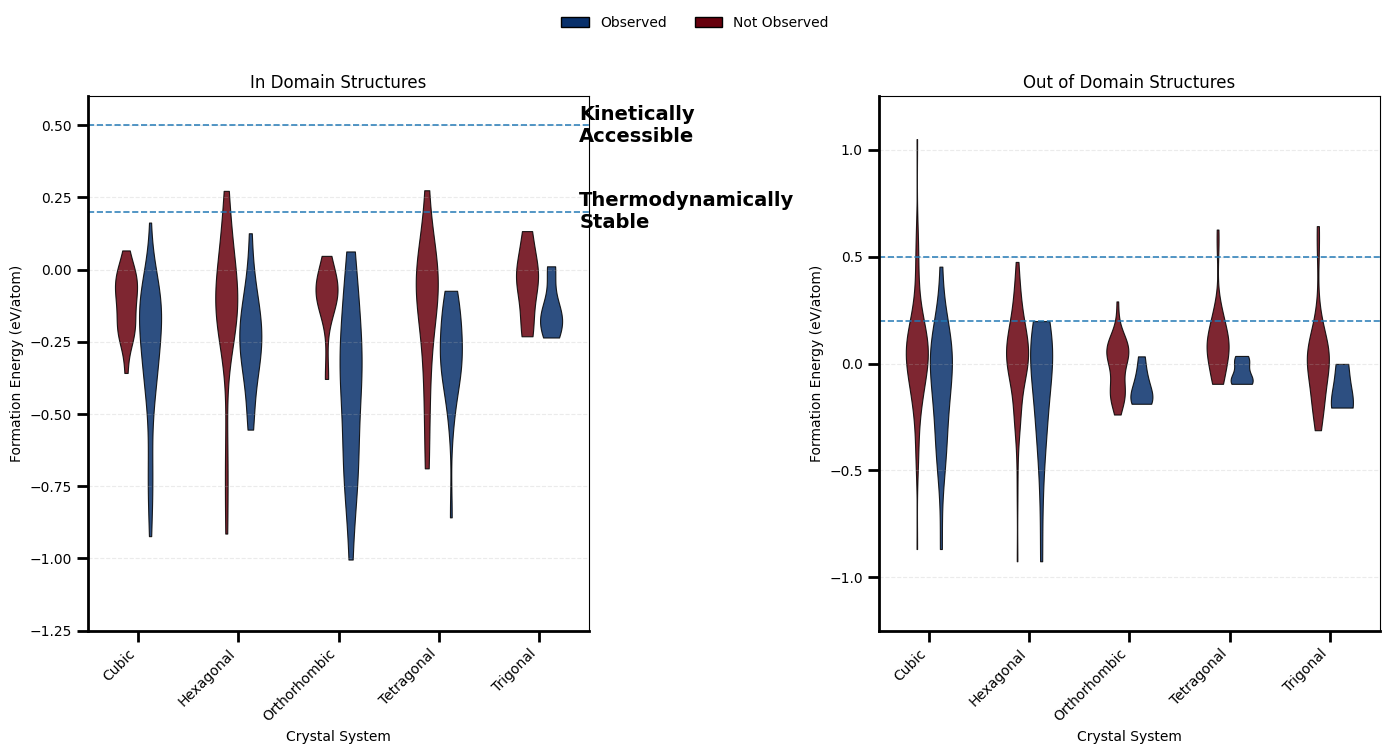

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
from matplotlib.patches import Patch

YCOL = "formation_energy_per_atom"
XCAT = "crystal_system"
HUE  = "experimentally_observed"      # boolean column

DECOMP_ENERGY   = 0.2
KINETIC_BARRIER = 0.5

COL_OBS  = "#08306B"  # dark blue
COL_NOBS = "#67000D"  # dark red
EDGE     = "black"

def _color_violins(vdict, face, edge=EDGE, alpha=0.85, lw=0.8):
    for b in vdict["bodies"]:
        b.set_facecolor(face)
        b.set_edgecolor(edge)
        b.set_alpha(alpha)
        b.set_linewidth(lw)

def _panel(ax, df, ylim):
    cats = sorted(df[XCAT].astype(str).unique())
    pos  = np.arange(1, len(cats) + 1, dtype=float)
    off  = 0.12

    d_false = [df[(df[XCAT].astype(str) == c) & (~df[HUE])][YCOL].values for c in cats]
    d_true  = [df[(df[XCAT].astype(str) == c) & ( df[HUE])][YCOL].values for c in cats]

    v_false = ax.violinplot(d_false, positions=pos - off, widths=0.22,
                            showmeans=False, showextrema=False, showmedians=False)
    v_true  = ax.violinplot(d_true,  positions=pos + off, widths=0.22,
                            showmeans=False, showextrema=False, showmedians=False)

    _color_violins(v_false, COL_NOBS)
    _color_violins(v_true,  COL_OBS)

    ax.axhline(DECOMP_ENERGY,   linestyle="--", linewidth=1.2, alpha=0.9)
    ax.axhline(KINETIC_BARRIER, linestyle="--", linewidth=1.2, alpha=0.9)

    ax.set_ylim(ylim)
    ax.set_xlim(0.5, len(cats) + 0.5)
    ax.grid(axis="y", linestyle="--", alpha=0.25, zorder=0)
    ax.set_xlabel("Crystal System")
    ax.set_ylabel("Formation Energy (eV/atom)")
    ax.xaxis.set_minor_locator(NullLocator())
    ax.yaxis.set_minor_locator(NullLocator())
    ax.tick_params(axis="x", which="major", direction="out", length=8, width=2, rotation=45)
    ax.tick_params(axis="y", which="major", direction="out", length=8, width=2)
    for sp in ("bottom", "left"):
        ax.spines[sp].set_linewidth(2)

    # ≤5 evenly spaced tick labels
    if len(cats) <= 5:
        tick_pos, tick_lab = pos, cats
    else:
        idx = sorted({int(round(i)) for i in np.linspace(0, len(cats) - 1, 5)})[:5]
        tick_pos = pos[idx]
        tick_lab = [cats[i] for i in idx]
    ax.set_xticks(tick_pos, tick_lab)
    for lab in ax.get_xticklabels():
        lab.set_ha("right")

# ---- Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

_panel(ax1, df_in,           ylim=(-1.25, 0.60))
_panel(ax2, df_out_updated,  ylim=(-1.25, 1.25))

ax1.set_title("In Domain Structures")
ax2.set_title("Out of Domain Structures")

# --- Annotations on left panel
ax1.text(0.98, KINETIC_BARRIER, "Kinetically\nAccessible",
         fontsize=14, fontweight="bold", ha="left", va="center",
         transform=ax1.get_yaxis_transform(which="grid"))
ax1.text(0.98, DECOMP_ENERGY, "Thermodynamically\nStable",
         fontsize=14, fontweight="bold", ha="left", va="center",
         transform=ax1.get_yaxis_transform(which="grid"))

# shared legend
handles = [Patch(facecolor=COL_OBS,  edgecolor=EDGE, label="Observed"),
           Patch(facecolor=COL_NOBS, edgecolor=EDGE, label="Not Observed")]
fig.legend(handles=handles, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.08))

plt.tight_layout()

base = "/content/formation_energy_stability"
for ext in ("pdf", "png", "tiff"):
    plt.savefig(f"{base}.{ext}", dpi=600, bbox_inches="tight", facecolor="white")

plt.show()


In [44]:
df_out_updated['bulk_id'].nunique()

235

In [45]:
df_out_updated

,chemsys,bulk_id,formula_pretty,crystal_system,spacegroup,volume,formation_energy_per_atom,band_gap,experimentally_observed,in_domain,atoms
0,Ir-Pt,mp-1223665,IrPt,Trigonal,R-3m,30.221598,0.081435,0.0,False,False,"(Atom('Ir', [np.float64(0.0), np.float64(0.0),..."
1,Ir-Pt,mp-1184759,IrPt3,Cubic,Pm-3m,61.688543,0.081637,0.0,False,False,"(Atom('Ir', [np.float64(0.0), np.float64(0.0),..."
2,Ir-Ni,mp-1220071,NiIr,Trigonal,R-3m,25.239142,0.035064,0.0,False,False,"(Atom('Ni', [np.float64(6.06594804), np.float6..."
3,Ir-Ni,mp-1186350,NiIr3,Tetragonal,I4/mmm,53.796769,0.011985,0.0,False,False,"(Atom('Ni', [np.float64(0.0), np.float64(0.0),..."
4,Fe-Ir,mp-1224967,FeIr,Trigonal,R-3m,27.166181,0.014804,0.0,False,False,"(Atom('Fe', [np.float64(0.0), np.float64(0.0),..."
...,...,...,...,...,...,...,...,...,...,...,...
233,Co-Mo,mp-1079042,Co6Mo2,Hexagonal,P6_3/mmc,90.915359,0.125987,0.0,True,False,"(Atom('Co', [np.float64(-1.2451494486343428), ..."
234,Fe-Nb,mp-937052,Fe8Nb4,Hexagonal,P6_3/mmc,159.627063,-0.042595,0.0,True,False,"(Atom('Nb', [np.float64(-2.38551838), np.float..."
235,Cu-Ti,mp-990243,Cu3Ti2,Tetragonal,I4/mmm,68.214813,-0.089346,0.0,True,False,"(Atom('Ti', [np.float64(1.58623982), np.float6..."
236,Mo-Ni,mp-1079496,Mo2Ni6,Orthorhombic,Pmmn,92.470425,-0.052449,0.0,True,False,"(Atom('Ni', [np.float64(0.005805912511812), np..."


### <a name="sec-step5-vasp"></a> Step 5 – Generate VASP Input Decks


> ⚠️ **VASP license required**  
> The next cell writes full VASP input folders from each `ase.Atoms` object.  
> You must be an **authorized VASP user** with access to PAW-PBE POTCARs; otherwise the cell will fail and you may violate the VASP EULA.

| File        | Purpose (edit paths marked **EDIT HERE**) |
|-------------|-------------------------------------------|
| `POSCAR`    | Bulk geometry from `ase.Atoms`. |
| `KPOINTS`   | Fixed Γ-centered 10 × 10 × 10 mesh. |
| `INCAR`     | Generic bulk‐relax settings (`BULK_VASP_FLAGS`). |
| `POTCAR`    | Concatenated from `<POTCAR_DIR>/<elem>/POTCAR`. |
| `job.sh`    | Example SLURM script — adapt queue, time, modules. |

**Customise before running**

1. **`BASE_DIR`** – where run folders are created *(EDIT HERE)*.  
2. **`POTCAR_DIR`** – root of your pseudopotential library *(EDIT HERE)*.  
3. `write_batch_script()` – tweak `#SBATCH` lines for your HPC.  

The helper routines are cluster-agnostic; only path strings and the SLURM header are site-specific.

After relaxation, results are uploaded to Google Drive; the notebook then parses each `OUTCAR`, converts the relaxed structures back to pickled `ase.Atoms`, and feeds them into the downstream MLIP relaxation sub-routine.  
A full end-to-end demonstration is available in the companion tutorial:  
<https://github.com/ergroup/EqV2-HER-Discovery/blob/main/notebooks/demo_InDomain_H_ads.ipynb>


In [46]:
# ----------------------------------------------------------------------------------
# 1) VASP flags for OC20 bulk (check the github repository https://github.com/Open-Catalyst-Project/Open-Catalyst-Dataset/blob/main/ocdata/utils/vasp.py)
# ----------------------------------------------------------------------------------
BULK_VASP_FLAGS = {
    "ibrion": 1,         # ionic optimisation (quasi‑Newton)
    "nsw": 100,          # max ionic steps
    "isif": 7,           # relax both ions and cell
    "isym": 0,           # symmetry off (safer for low‑symmetry structures)
    "ediffg": 1e-8,      # force‑convergence criterion
    "encut": 500.0,      # plane‑wave cutoff (eV)
    "kpts": (10, 10, 10),
    "prec": "Accurate",
    "gga": "RP",
    "pp":  "PBE",
    "lwave":  False,
    "lcharg": False,
}

# ----------------------------------------------------------------------------------
# 2) File‑writer helpers
# ----------------------------------------------------------------------------------
def write_poscar(atoms: Atoms, folder: str):
    """POSCAR from ASE Atoms."""
    write(Path(folder, "POSCAR"), atoms, format="vasp")

def write_kpoints(folder: str):
    k0, k1, k2 = BULK_VASP_FLAGS["kpts"]
    Path(folder, "KPOINTS").write_text(
        f"Automatic mesh\n0\nMonkhorst–Pack\n{k0} {k1} {k2}\n0 0 0\n"
    )

def create_potcar(folder: str, potcar_root: str):
    """
    Concatenate POTCAR fragments – requires
    `<potcar_root>/<Element>/POTCAR` for every species in POSCAR.
    """
    elems = Path(folder, "POSCAR").read_text().splitlines()[5].split()
    txt = []
    for Z in elems:
        psrc = Path(potcar_root, Z, "POTCAR")
        if not psrc.is_file():
            raise FileNotFoundError(f"No POTCAR for {Z} → {psrc}")
        txt.append(psrc.read_text())
    Path(folder, "POTCAR").write_text("".join(txt))

def write_incar(folder: str):
    lines = []
    for k, v in BULK_VASP_FLAGS.items():
        v_fmt = ".TRUE." if v is True else ".FALSE." if v is False else v
        lines.append(f"{k.upper()} = {v_fmt}")
    Path(folder, "INCAR").write_text("\n".join(lines))

def write_batch_script(folder: str):
    """
    Example SLURM launcher  – **edit for your HPC environment**.
    """
    job = Path(folder).name
    Path(folder, "job.sh").write_text(f"""#!/bin/bash
#SBATCH -N xx                  # <<< EDIT HERE
#SBATCH -n xx                  # <<< EDIT HERE
#SBATCH --time=xx:00:00       # <<< EDIT HERE
#SBATCH -p xxx              # <<< EDIT HERE
#SBATCH -J {job}
#SBATCH --output=out.%j
#SBATCH --error=err.%j

module load xx             # <<< EDIT HERE
module load VASP5/5.4.4.xx  # <<< EDIT HERE
srun vasp_std > vasp.out
""")

# ----------------------------------------------------------------------------------
# 3) Driver – iterate over DataFrame rows
# ----------------------------------------------------------------------------------
def generate_vasp_inputs(df, base_dir, potcar_dir):
    """
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'bulk_id' and 'atoms'.
    base_dir : str or Path
        Parent directory where <bulk_id>/ folders will be created.
    potcar_dir : str or Path
        Root folder containing element‑wise POTCAR sub‑dirs.
    """
    base_dir  = Path(base_dir).expanduser().resolve()
    potcar_dir = Path(potcar_dir).expanduser().resolve()
    base_dir.mkdir(parents=True, exist_ok=True)

    for _, row in df.iterrows():
        bid   = row["bulk_id"]
        atoms = row["atoms"]
        work  = base_dir / bid
        work.mkdir(exist_ok=True)

        write_poscar(atoms, work)
        write_kpoints(work)
        create_potcar(work, potcar_dir)
        write_incar(work)
        write_batch_script(work)

        print(f"✔  VASP inputs written → {work}")

# ----------------------------------------------------------------------------------
# 4) Example call  (uncomment & adapt paths)
# ----------------------------------------------------------------------------------
# BASE_DIR   = "/path/to/vasp_runs/out_of_domain"   # <<< EDIT HERE
# POTCAR_DIR = "/path/to/pseudopotentials"          # <<< EDIT HERE
# generate_vasp_inputs(df_out_updated, BASE_DIR, POTCAR_DIR)

### <a name="sec-outcar-extract"></a>Step 6 – Build the **Out‑of‑Domain** Bulk Pickle from VASP *OUTCAR*s  
This cell harvests **fully‑relaxed bulk geometries and their single‑point energies** from VASP calculations that were executed for the out‑of‑domain candidates identified earlier.

**Workflow**

1. **User parameters**  
   * `base_directory` – root folder that contains one sub‑directory per material (`mp‑*`), each holding an `OUTCAR`.  
   * `output_pickle`  – target path for the consolidated pickle (`OutOfDomainBulk.pkl`).  
   * `sampling_template` – optional string for attaching an arbitrary provenance tag (`bulk_sampling_str`).

2. **Iterate through `mp‑*/OUTCAR` files**  
   * Skip folders without a valid `OUTCAR`.  
   * Read the **final frame** (`index = -1`) with `ase.io.read`, which attaches a `SinglePointCalculator` containing the converged total energy, forces, and stress.

3. **Integrity checks**  
   * Verify that the attached calculator is indeed an `ase.calculators.singlepoint.SinglePointCalculator`.  
   * Emit warnings for missing or malformed outputs without interrupting the loop.

4. **Collect metadata**  
   * Store `src_id` (folder name), a random `bulk_sampling_str` (for traceability), and the full `Atoms` object (including the calculator).

5. **Serialise**  
   * Dump the accumulated list to `output_pickle` with `pickle.HIGHEST_PROTOCOL`.

**Outcome**  
A single file — `OutOfDomainBulk.pkl` — that bundles every out‑of‑domain bulk structure together with its DFT total energy, ready for downstream modelling or database ingestion.



In [47]:
# ─── User parameters ─────────────────────────────────────────────────────────
base_directory = "/content/drive/MyDrive/OutOfDomain"   # folder containing mp-*/OUTCAR
output_pickle  = "/content/OutOfDomainBulk.pkl"
sampling_template = "{run}/{step}_{run2}/{step2}"       # sampling
# ─────────────────────────────────────────────────────────────────────────────

atoms_list = []

for subdir in sorted(os.listdir(base_directory)):
    if not subdir.startswith("mp-"):
        continue

    outcar_path = os.path.join(base_directory, subdir, "OUTCAR")
    if not os.path.isfile(outcar_path):
        print(f"⚠️  OUTCAR missing for {subdir}, skipping")
        continue

    try:
        # read final frame with attached SinglePointCalculator
        atoms = read(outcar_path, format="vasp-out", index=-1)
    except Exception as e:
        print(f"❌ Failed to read {outcar_path}: {e}")
        continue

    # Sanity check: calculator should now be a SinglePointCalculator
    calc = atoms.calc
    if not isinstance(calc, SinglePointCalculator):
        print(f"⚠️  {subdir}: got calc={calc!r} (not SinglePointCalculator)")

    # build your sampling string however you like
    sampling_str = sampling_template.format(
        run    = random.randint(0,999),
        step   = random.randint(0,9999),
        run2   = random.randint(0,999),
        step2  = random.randint(0,9999),
    )

    atoms_list.append({
        "src_id":            subdir,
        "bulk_sampling_str": sampling_str,
        "atoms":             atoms,      # store the real Atoms w/ calculator
    })
    print(f"✅ Loaded and stored {subdir}")

# write out the pickle
with open(output_pickle, "wb") as f:
    pickle.dump(atoms_list, f)

print(f"\n🎉 Pickled {len(atoms_list)} structures → {output_pickle}")


✅ Loaded and stored mp-1006883
✅ Loaded and stored mp-1006884
✅ Loaded and stored mp-1007852
✅ Loaded and stored mp-1007853
✅ Loaded and stored mp-1007854
✅ Loaded and stored mp-1007862
✅ Loaded and stored mp-1008279
✅ Loaded and stored mp-1009134
✅ Loaded and stored mp-1009206
✅ Loaded and stored mp-1009207
✅ Loaded and stored mp-1009217
✅ Loaded and stored mp-1009264
✅ Loaded and stored mp-1009826
✅ Loaded and stored mp-1018023
✅ Loaded and stored mp-1018145
✅ Loaded and stored mp-1058696
✅ Loaded and stored mp-10635
✅ Loaded and stored mp-1063561
✅ Loaded and stored mp-1064220
✅ Loaded and stored mp-1065741
✅ Loaded and stored mp-1066232
✅ Loaded and stored mp-1071283
✅ Loaded and stored mp-1072076
✅ Loaded and stored mp-1072181
✅ Loaded and stored mp-1077083
✅ Loaded and stored mp-1077448
✅ Loaded and stored mp-1077745
✅ Loaded and stored mp-1079042
✅ Loaded and stored mp-1079496
✅ Loaded and stored mp-1084832
✅ Loaded and stored mp-1095456
✅ Loaded and stored mp-1095682
✅ Loaded a

### <a name="sec-step7-package"></a> Step 7 – Package Merged Pickle


In [48]:
import pickle

# Paths to your input pickles
IN_DOMAIN_PKL       = "in_domain.pkl"
OUT_OF_DOMAIN_PKL   = "OutOfDomainBulk.pkl"
MERGED_PKL          = "Allbulks.pkl"

# 1) Load both lists
with open(IN_DOMAIN_PKL, "rb") as f:
    in_domain = pickle.load(f)

with open(OUT_OF_DOMAIN_PKL, "rb") as f:
    out_domain = pickle.load(f)

# 2) Combine and dedupe by src_id
combined = in_domain + out_domain
unique = {}
for entry in combined:
    src = entry.get("src_id")
    if src not in unique:
        unique[src] = entry

merged_list = list(unique.values())

# 3) Save merged list
with open(MERGED_PKL, "wb") as f:
    pickle.dump(merged_list, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Loaded {len(in_domain)} in‑domain + {len(out_domain)} out‑of‑domain entries")
print(f"Merged (unique) entries: {len(merged_list)} → saved as {MERGED_PKL}")


Loaded 204 in‑domain + 235 out‑of‑domain entries
Merged (unique) entries: 439 → saved as Allbulks.pkl


In [49]:
# Path to your pickled data
pkl_path = '/content/Allbulks.pkl'

# Load the list of dicts
with open(pkl_path, 'rb') as f:
    bulk_data = pickle.load(f)

# Iterate and extract energy
for entry in bulk_data:
    src_id = entry.get('src_id')
    atoms  = entry.get('atoms')
    calc   = getattr(atoms, 'calc', None)

    if isinstance(calc, SinglePointCalculator):
        energy = calc.results.get('energy', None)
    else:
        energy = None

    print(f"src_id: {src_id}, Total Energy: {energy}")


src_id: mp-2083, Total Energy: -16.02471049
src_id: mp-10598, Total Energy: -13.53691247
src_id: mp-1030, Total Energy: -42.78166123
src_id: mp-2260, Total Energy: -12.93008258
src_id: mp-949, Total Energy: -23.5879029
src_id: mp-10125, Total Energy: -24.65551817
src_id: mp-1418, Total Energy: -21.80668663
src_id: mp-1008349, Total Energy: -23.51885884
src_id: mp-865193, Total Energy: -48.55332201
src_id: mp-601820, Total Energy: -27.62542045
src_id: mp-922, Total Energy: -22.71024472
src_id: mp-9835, Total Energy: -28.89776578
src_id: mp-11798, Total Energy: -55.80547897
src_id: mp-11523, Total Energy: -18.86186048
src_id: mp-20033, Total Energy: -24.26947456
src_id: mp-20112, Total Energy: -38.07228347
src_id: mp-11522, Total Energy: -19.0416284
src_id: mp-601842, Total Energy: -106.92513824
src_id: mp-1007855, Total Energy: -21.92429554
src_id: mp-10260, Total Energy: -19.02412299
src_id: mp-976847, Total Energy: -19.13592521
src_id: mp-12608, Total Energy: -42.07542947
src_id: mp-1

In [50]:
df_out_updated

,chemsys,bulk_id,formula_pretty,crystal_system,spacegroup,volume,formation_energy_per_atom,band_gap,experimentally_observed,in_domain,atoms
0,Ir-Pt,mp-1223665,IrPt,Trigonal,R-3m,30.221598,0.081435,0.0,False,False,"(Atom('Ir', [np.float64(0.0), np.float64(0.0),..."
1,Ir-Pt,mp-1184759,IrPt3,Cubic,Pm-3m,61.688543,0.081637,0.0,False,False,"(Atom('Ir', [np.float64(0.0), np.float64(0.0),..."
2,Ir-Ni,mp-1220071,NiIr,Trigonal,R-3m,25.239142,0.035064,0.0,False,False,"(Atom('Ni', [np.float64(6.06594804), np.float6..."
3,Ir-Ni,mp-1186350,NiIr3,Tetragonal,I4/mmm,53.796769,0.011985,0.0,False,False,"(Atom('Ni', [np.float64(0.0), np.float64(0.0),..."
4,Fe-Ir,mp-1224967,FeIr,Trigonal,R-3m,27.166181,0.014804,0.0,False,False,"(Atom('Fe', [np.float64(0.0), np.float64(0.0),..."
...,...,...,...,...,...,...,...,...,...,...,...
233,Co-Mo,mp-1079042,Co6Mo2,Hexagonal,P6_3/mmc,90.915359,0.125987,0.0,True,False,"(Atom('Co', [np.float64(-1.2451494486343428), ..."
234,Fe-Nb,mp-937052,Fe8Nb4,Hexagonal,P6_3/mmc,159.627063,-0.042595,0.0,True,False,"(Atom('Nb', [np.float64(-2.38551838), np.float..."
235,Cu-Ti,mp-990243,Cu3Ti2,Tetragonal,I4/mmm,68.214813,-0.089346,0.0,True,False,"(Atom('Ti', [np.float64(1.58623982), np.float6..."
236,Mo-Ni,mp-1079496,Mo2Ni6,Orthorhombic,Pmmn,92.470425,-0.052449,0.0,True,False,"(Atom('Ni', [np.float64(0.005805912511812), np..."


In [51]:
# 1️⃣  remove the atoms column
df_out_clean = df_out_updated.drop(columns=['atoms'])

# 2️⃣  concatenate the two dataframes row-wise
df_merged = pd.concat([df_in, df_out_clean], ignore_index=True)

# 3️⃣  save to disk without the pandas index
csv_name = "bulk_in_out_merged.csv"
df_merged.to_csv(csv_name, index=False)

print(f"✓ Saved merged file → {csv_name}  (rows: {len(df_merged)})")


✓ Saved merged file → bulk_in_out_merged.csv  (rows: 439)


## <a name="sec-conclusions"></a> Conclusions  

This notebook demonstrates an **end‑to‑end, reproducible workflow** for discovering and analysing bimetallic bulk materials:

1. **Data integration**  
   *Queried* the Materials Project for every unique binary combination of fourteen transition‑ and post‑transition‑metal elements, then *cross‑referenced* those entries with the **Open Catalyst 2020** (OC20) bulks dataset.  
   * Materials present in OC20 were labelled **in‑domain**; all others were classified **out‑of‑domain**.

2. **Data enrichment & curation**  
   * Filled missing crystal‑symmetry information via local `pymatgen` analysis when absent from the MP record.  
   * Completed gaps in key thermodynamic/electronic properties by selecting the most stable polymorph (lowest _E<sub>hull</sub>_) with identical composition and symmetry.

3. **Exploratory analysis**  
   * Violin‑plot comparison of formation energies revealed systematic stability trends across crystal systems and highlighted differences between *experimentally observed* and *theoretical* compounds.

4. **Down‑stream simulation readiness**  
   * Automatically generated **VASP** input packages (POSCAR, INCAR, KPOINTS, POTCAR, batch script) for every out‑of‑domain structure, enabling immediate high‑throughput first‑principles calculations.

---

Together, these steps provide a practical template for **high‑throughput screening in catalysis and materials discovery**.  
By combining large, curated databases with automated analysis and workflow tools, researchers can quickly target the most promising candidates for further experimental or computational investigation.



#### <a name="sec-references"></a>9. References  

##### 9.1 Data & Code  
- **OC20 bulk structures** (`bulks.pkl`) – ocdata/databases/pkls/bulks.pkl, Open Catalyst Dataset. GitHub.  
  https://github.com/Open-Catalyst-Project/Open-Catalyst-Dataset/blob/main/ocdata/databases/pkls/bulks.pkl  

- **VASP utility functions** (`vasp.py`) – ocdata/utils/vasp.py, Open Catalyst Dataset. GitHub.  
  https://github.com/Open-Catalyst-Project/Open-Catalyst-Dataset/blob/main/ocdata/utils/vasp.py  

##### 9.2 Key Publications  
- Chanussot, L.; Das, A.; Goyal, S.; Lavril, T.; Shuaibi, M.; Rivière, M.; Tran, K.; Heras‑Domingo, J.; Ho, C.; Hu, W.; Palizhati, A.; Sriram, A.; Wood, B.; Yoon, J.; Parikh, D.; Zitnick, C. L.; Ulissi, Z. Open Catalyst 2020 (OC20) Dataset and Community Challenges. *ACS Catalysis* **11**, 6059–6080 (2021). DOI: 10.1021/acscatal.0c04525  

- Jain, A.; Ong, S. P.; Hautier, G.; Chen, W.; Richards, W. D.; Dacek, S.; Cholia, S.; Gunter, D.; Skinner, D.; Ceder, G.; Persson, K. A. Commentary: The Materials Project: A materials genome approach to accelerating materials innovation. *APL Materials* **1**, 011002 (2013). DOI: 10.1063/1.4812323  

